In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
#function of u and d
def f_u(b,T,n,sigma):
    h = T/n
    return np.exp(b*h+ sigma*np.sqrt(h))
def f_d(b,T,n,sigma):
    h = T/n
    return np.exp(b*h- sigma*np.sqrt(h))
def f_R(r,T,n):
    return np.exp(r*T/n)

In [3]:
# Question 1
#(a)
def Sn(T,n,b,sigma,j,S0):
    u = f_u(b,T,n,sigma)
    d = f_d(b,T,n,sigma)
    S = [S0*(u**(j-i))*(d**(i)) for i in range(j+1)]
    S = np.array(S)
    return S
#b
def Payoffn(T,n,b,sigma,K,S0):
    S  = Sn(T,n,b,sigma,n,S0)
    pay = S-K
    return pay*(pay>0)
#c
def Calln(T,n,r,b,sigma,K,S0):
    R = np.exp(r*T/n)
    u = f_u(b,T,n,sigma)
    d = f_d(b,T,n,sigma)
    q = (R-d)/(u-d)
    probs = np.array([sts.binom.pmf(k,n,1-q) for k in range(n+1)])
    price = np.exp(-r*T)* np.sum(Payoffn(T,n,b,sigma,K,S0)*probs)
    return price
#d
def Deltan(T,n,r,b,sigma,K,j,S0):
    u = f_u(b,T,n,sigma)
    d = f_d(b,T,n,sigma)
    R = f_R(r,T,n)
    q = (R-d)/(u-d)
    # S_{j+1}
    S = Sn(T,n,b,sigma,j+1,S0)
    B = [] # B_{j+1}
    #proba from j+1 to n
    probs = np.array([sts.binom.pmf(k,n-j-1,1-q) for k in range(n-j-1)])
    # payoff at maturity
    payoff_n = Payoffn(T,n,b,sigma,K,S0)
    t = T/n*(j+1)
    delta = []
    for i in range(len(S)):        
        B.append(np.exp(-r*(T-t))* np.sum(payoff_n[i:i+n-j-1]*probs))
    for i in range(len(B)-1):
        delta.append((B[i]-B[i+1])/(S[i]-S[i+1]))
    return delta

In [4]:
"""
Black-Scholes price and delta
"""
def d_plus(sigma,T,t,S,K,r):
    return 1./(sigma*np.sqrt(T-t))*(np.log(S/K)+(r+sigma*sigma/2.)*(T-t))
    
def d_minus(sigma,T,t,S,K,r):
    return d_plus(sigma,T,t,S,K,r) - sigma*np.sqrt(T-t)

def Delta_BS(T,n,r,b,sigma,K,j,S0):
    S = Sn(T,n,b,sigma,j,S0)
    t = T/n*j
    d1 = d_plus(sigma,T,t,S,K,r)
    return sts.norm.cdf(d1)
#2 (a)
def Call(T,r,sigma,K,S0):
    d1 = d_plus(sigma,T,0,S0,K,r)
    d2 = d_minus(sigma,T,0,S0,K,r)
    return S0*sts.norm.cdf(d1) - K*np.exp(-r*T)*sts.norm.cdf(d2)

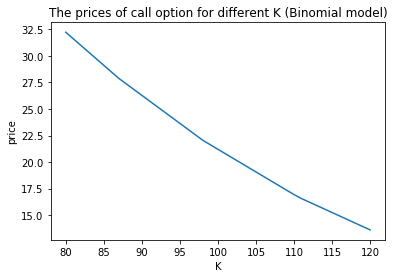

In [5]:
# Question 1, explore the relation between price and strike K
n= 50
sigma = 0.3
r = 0.05
b = 0.05
T =2
S0 = 100
K_list = [80+i for i in range(41)]
price_list = [Calln(T,n,r,b,sigma,k,S0) for k in K_list]
plt.figure()
plt.plot(K_list,price_list)
plt.xlabel('K')
plt.ylabel('price')
plt.title('The prices of call option for different K (Binomial model)')
plt.show()

# Conclusion 1
The price of the option decreases as the strike K increases, which means the value of the call option is lower if the strike is high. Because for a given S0 (100 here), it is more difficult to have S_T>K if K is high, then the option is useless, thus, the value of this option decreases with the strike K. The call price is convex relative to K.

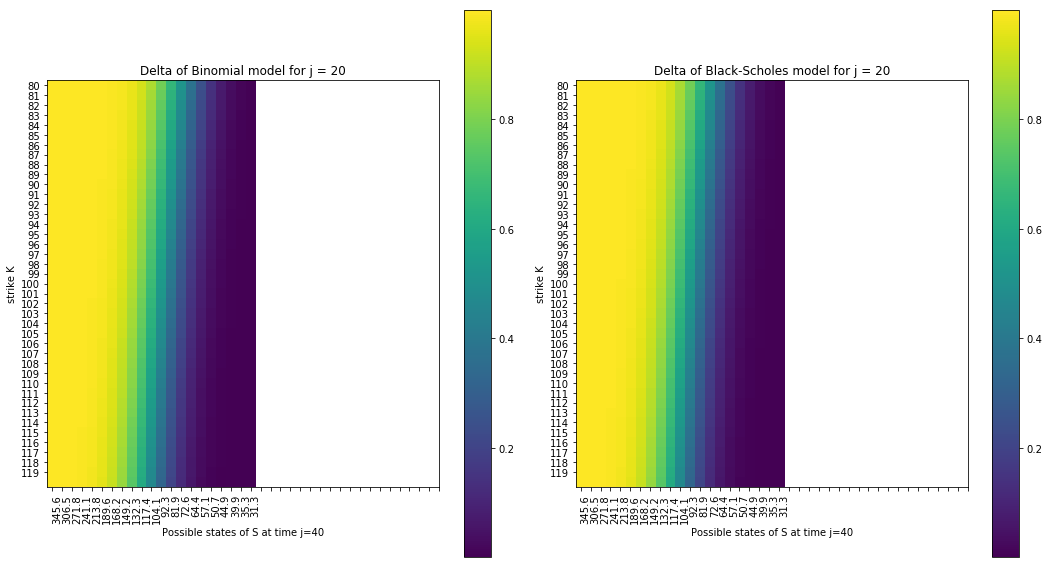

In [6]:
j = 20
S = [round(s,1)for s in Sn(T,n,b,sigma,j,S0)]
delta = np.array([Deltan(T,n,r,b,sigma,k,j,S0) for k in K_list])
delta_BS = np.array([Delta_BS(T,n,r,b,sigma,k,j,S0) for k in K_list])
    
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 8))
im = ax.imshow(delta)
ax.set_title("Delta of Binomial model for j = "+str(j))
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("Possible states of S at time j=40")
ax.set_ylabel("strike K")
ax.set_yticks(np.arange(40))
ax.set_yticklabels(K_list)
ax.set_xticks(np.arange(40))
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
ax.set_xticklabels(S)

im2 = ax2.imshow(delta_BS)
ax2.set_title("Delta of Black-Scholes model for j = "+str(j))
cbar2 = ax2.figure.colorbar(im2, ax=ax2)
ax2.set_xlabel("Possible states of S at time j=40")
ax2.set_ylabel("strike K")
ax2.set_yticks(np.arange(40))
ax2.set_yticklabels(K_list)
ax2.set_xticks(np.arange(40))
plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
ax2.set_xticklabels(S)

fig.tight_layout()
plt.show()

# Conclusion 2
The deltas calculated by Binomial model have little difference with the delta calculated by Black Scholes model. For deep in the money calls, the delta is nealy 1, which means the price of the option moves with the underlying. To hedge the risk of such call options, the issuer should hold nearly one position of the underlying. For deep out of the money calls, the delta is nealy 0, which means the price of the option does not change with the underlying. The issuer does not hold the position of underlying to hedge the risk of such call options. For at the money calls, the option price is sensitive to the price change of the underlying, and the delta changes really quick, so the gamma of at-the-money calls is very big.

In [7]:
#Question 2
K = 105
call_BS = Call(T,r,sigma,K,S0)
nn = [10*i for i in range(1,101)]
call_n = [Calln(T,n,r,b,sigma,K,S0) for n in nn]
err = [call/call_BS-1 for call in call_n]

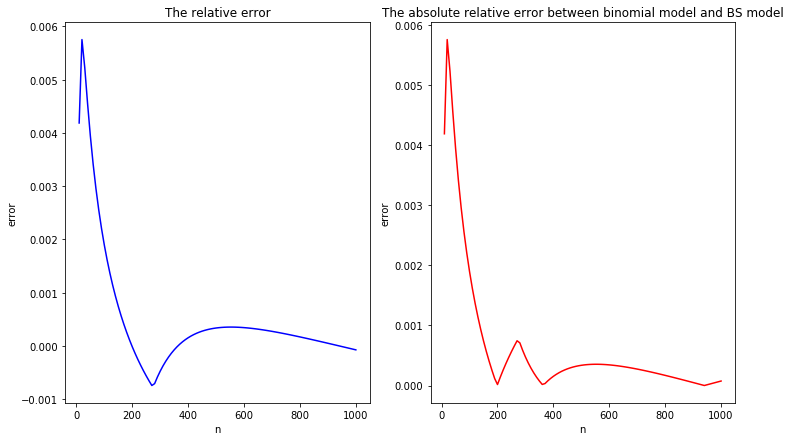

In [8]:

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(nn,err, 'b', label = "err")
plt.xlabel('n')
plt.ylabel('error')
plt.title('The relative error')
plt.subplot(1,2,2)
plt.plot(nn,np.abs(err), 'r', label = "abs(err)")
plt.xlabel('n')
plt.ylabel('error')
plt.title('The absolute relative error between binomial model and BS model')
plt.show()

# Conclusion 3

The relative errors between binomial model and Black-Scholes model converge to 0 as n tends to infinity
